## Author: Maxence Gélard
maxence.gelard@student-cs.fr


# Small data and deep learning
This pratical session proposes to study several techniques to improve training performance in the challenging context where few data and resources are available.

# Introduction
Assume we are in a context where few "gold" labeled data are available for training, say $\mathcal{X}_{\text{train}}\triangleq\{(x_n,y_n)\}_{n\leq N_{\text{train}}}$, where $N_{\text{train}}$ is small. A large test set $\mathcal{X}_{\text{test}}$ is available. A large amount of unlabeled data, $\mathcal{X}_{\text{nolabel}}$, is available. We also assume that we have a limited computational budget (e.g., no GPUs).

For each question, write a commented *Code* or a complete answer as a *Markdown*. When the objective of a question is to report a CNN accuracy, please use the following format to report it, at the end of the question :


| Model | Number of  epochs  | Train accuracy | Test accuracy |
|------|------|------|------|
|   XXX  | XXX | XXX | XXX |


If applicable, please add the field corresponding to the  __Accuracy on Full Data__ as well as a link to the __Reference paper__ you used to report those numbers. (You do not need to train a CNN on the full CIFAR10 dataset.)

In your final report, please keep the logs of each training procedure you used. We will only run this jupyter if we have some doubts on your implementation. 

__The total file sizes should be reasonable (feasible with 2MB only!). You will be asked to hand in the notebook, together with any necessary files required to run it if any.__


To run your experiments, you can use the same local installation as for previous TPs, or otherwise https://colab.research.google.com/.

In [1]:
from collections import Counter

import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader
from torch.utils.data.sampler import Sampler
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
from tqdm import tqdm

device = 'cuda' if torch.cuda.is_available() else 'cpu'

## Training set creation
__Question 1 (2 points) :__ Propose a dataloader that will only use the first 100 samples of the CIFAR-10 training set. 

*Hint* : You can modify the file located at https://github.com/pytorch/vision/blob/master/torchvision/datasets/cifar.py or use the information from https://pytorch.org/vision/stable/datasets.html

This is our dataset $\mathcal{X}_{\text{train}}$, it will be used until the end of this project. The remaining samples correspond to $\mathcal{X}_{\text{nolabel}}$. The testing set $\mathcal{X}_{\text{test}}$ corresponds to the whole testing set of CIFAR-10.

In [2]:
class CIFAR10Dataset:
    def __init__(self, file_location,
                 transform_train = transforms.ToTensor(),
                 transform_test = transforms.ToTensor(),
                 n_training_examples: int = 100,
                 batch_size: int = 10,
                 n_no_labels_examples = None
                ):
        self.file_location = file_location
        self.n_training_examples = n_training_examples # size of X_train
        self.batch_size = batch_size
        self.n_no_labels_examples = n_no_labels_examples # size of X_nolabel
        self.transform_train = transform_train
        self.transform_test = transform_test
        

        self.train_set = None
        self.train_set_no_label = None
        self.test_set = None
        
        self.get_datasets()
        
        self.train_loader = None
        self.train_loader_no_label = None
        self.test_loader = None
        
        self.get_dataloaders()
        
        
    def get_datasets(self):
        """
        Build the CIFAR10 dataset, applying transformation if provided
        """
        cifar_10_full_train_set = torchvision.datasets.CIFAR10(
            root=self.file_location,
            train=True,
            download=True,
            transform=self.transform_train
        )

        cifar_10_test_set = torchvision.datasets.CIFAR10(
            root=self.file_location,
            train=False,
            download=True,
            transform=self.transform_test
        )
        
        train_labeled_index = list(range(0, self.n_training_examples))
        if self.n_no_labels_examples:
          train_no_label_index = list(range(
              self.n_training_examples, self.n_no_labels_examples + self.n_training_examples
          ))
        else:
          train_no_label_index = list(range(self.n_training_examples, len(cifar_10_full_train_set)))
           
        cifar_10_train_set = torch.utils.data.Subset(cifar_10_full_train_set, train_labeled_index)
        cifar_10_train_set_no_label = torch.utils.data.Subset(cifar_10_full_train_set, train_no_label_index)
        
        self.train_set = cifar_10_train_set
        self.train_set_no_label = cifar_10_train_set_no_label
        self.test_set = cifar_10_test_set
        
    def get_dataloaders(self):
        """
        Build the dataloader that will be used during training
        """
        self.train_loader = DataLoader(
            dataset=self.train_set,
            batch_size=self.batch_size,
            shuffle=True,
        )

        self.train_loader_no_label = DataLoader(
            dataset=self.train_set_no_label,
            batch_size=self.batch_size,
            shuffle=True,
        )

        self.test_loader = DataLoader(
            dataset=self.test_set,
            batch_size=self.batch_size,
            shuffle=True,
        )

In [3]:
def compute_dataset_statistic(train_loader):
    """
    Compute mean and standart deviation on the training set
    """
    cumulated_sum = torch.zeros((3, 32, 32))
    cumulated_sum_square = torch.zeros((3, 32, 32))
    n_batch = 0
    for image_batch, _ in iter(train_loader):
        n_batch += 1
        cumulated_sum += image_batch.sum(0)
        cumulated_sum_square += (image_batch ** 2).sum(0)
    mean = (cumulated_sum / 100).mean((1, 2))
    mean_square = (cumulated_sum_square / 100).mean((1, 2))
    std = torch.sqrt(mean_square - mean**2)
    return mean, std

In [4]:
cifar_10_dataset = CIFAR10Dataset(file_location="./")
train_mean, train_std = compute_dataset_statistic(cifar_10_dataset.train_loader)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./cifar-10-python.tar.gz to ./
Files already downloaded and verified


In [5]:
# Sanity check:

first_batch_images, first_batch_labels = iter(cifar_10_dataset.train_loader).next()

print(f"First training batch images (shape): {first_batch_images.shape}")
print(f"First traiing batch labels (shape): {first_batch_labels.shape}")

First training batch images (shape): torch.Size([10, 3, 32, 32])
First traiing batch labels (shape): torch.Size([10])


## Testing procedure
__Question 2 (1.5 points) :__ Explain why the evaluation of the training procedure is difficult. Propose several solutions.

#### Problems related to the evaluation of the training procedure

1. First, as we are only looking at the first 100 examples, it is very likely that we get an __imbalanced dataset__ in terms of classes. Let's have a look a the repartition of classes:

Text(0.5, 1.0, 'Repartition of the class labels in the training set')

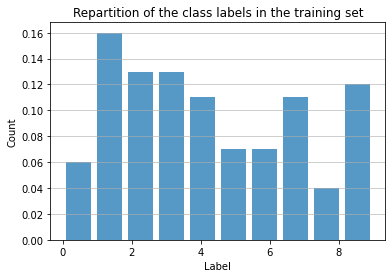

In [6]:
all_labels = []
for _, batch_labels in iter(cifar_10_dataset.train_loader):
    all_labels += list(map(lambda x: int(x), batch_labels))
    
plt.hist(all_labels, alpha=0.75, rwidth=0.8, weights=[1 / len(all_labels) for _ in all_labels])
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Label')
plt.ylabel('Count')
plt.title("Repartition of the class labels in the training set")

One can thus observe that some labels are significantly more represented than other (like label 1 vs. label 7), therefore any learned predictor will be __biased__ toward this skewed distribution.

A naive solution, given the fact that we have access to the full labeled dataset in reality, would be to build our labeled dataset of 100 examples by selected 10 random examples of each class, thus insuring the class balance. If we are not given the full dataset (closer to reality), we could imagine a data augmentation step that will generate as many examples as needed in order for each classes to be represented by the same number of examples. For instance, label 1 has 16 examples, so we could consider that we don't build any more example for this class ; whereas we may add 12 exampels for label 7 (which for now only has 4 examples) to reach the same number of examples as for label 1. We could also under-sample the dataset by only keeping the minimum number of examples that a label has, but that would make the dataset even smaller, which is not desirable.

2. A second problem concerns the model's hyperparameters tuning, which requires to build a __validation set__ from the training dataset. However, this would lead to a very small labeled dataset (even a 10% validation set would lead to have only 90 labeled training examples). 

A possible way to overcome this problem would be to use k-fold cross validation, thus allowing to test hyperparameters on all examples in the end. Another possibility would be to consider multiple models from which we would aggregate the predictions. There are two possibilities:

    - Either we do different train / validation for each model and tune them separately to get the best hyperparameters for each one.
    
    - Either all models are trained on the 100 examples but with different hyperparameters (given a range of hyperparameters that we think can provide good fit). This last idea is maybe more experimental.
    
3. More generally, having small dataset is an easy way to overfit 

We could consider semi-supervised methods or transfer learning to solve this issue.

# Raw approach: the baseline

In this section, the goal is to train a CNN on $\mathcal{X}_{\text{train}}$ and compare its performance with reported numbers from the litterature. You will have to re-use and/or design a standard classification pipeline. You should optimize your pipeline to obtain the best performances (image size, data augmentation by flip, ...).

The key ingredients for training a CNN are the batch size, as well as the learning rate schedule, i.e. how to decrease the learning rate as a function of the number of epochs. A possible schedule is to start the learning rate at 0.1 and decreasing it every 30 epochs by 10. In case of divergence, reduce the learning rate. A potential batch size could be 10, yet this can be cross-validated.

You can get some baselines accuracies in this paper : http://openaccess.thecvf.com/content_cvpr_2018/papers/Keshari_Learning_Structure_and_CVPR_2018_paper.pdf. Obviously, it is a different context for those researchers who had access to GPUs.

## ResNet architectures

__Question 3 (4 points) :__ Write a classification pipeline for $\mathcal{X}_{\text{train}}$, train from scratch and evaluate a *ResNet-18* architecture specific to CIFAR10 (details about the ResNet-18 model, originally designed for the ImageNet dataset, can be found here: https://arxiv.org/abs/1512.03385). Please report the accuracy obtained on the whole dataset as well as the reference paper/GitHub link.

*Hint:* You can re-use the following code: https://github.com/kuangliu/pytorch-cifar. During a training of 10 epochs, a batch size of 10 and a learning rate of 0.01, one obtains 40% accuracy on $\mathcal{X}_{\text{train}}$ (\~2 minutes) and 20% accuracy on $\mathcal{X}_{\text{test}}$ (\~5 minutes).

In [6]:
# Use of the ResNet implementation from
# https://github.com/kuangliu/pytorch-cifar

class BasicResNetBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicResNetBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class ResNet18(nn.Module):
    def __init__(self, num_classes=10):
        super(ResNet18, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(BasicResNetBlock, 64, 2, stride=1)
        self.layer2 = self._make_layer(BasicResNetBlock, 128, 2, stride=2)
        self.layer3 = self._make_layer(BasicResNetBlock, 256, 2, stride=2)
        self.layer4 = self._make_layer(BasicResNetBlock, 512, 2, stride=2)
        self.linear = nn.Linear(512*BasicResNetBlock.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

In [7]:
class ClassificationPipeline:
    def __init__(self, model, dataset: CIFAR10Dataset):
        self.model = model
        self.dataset = dataset
        
    def train(self, learning_rate: float, momentum: float, n_epochs: int):
        # Define the optimizing objects
        optimizer = torch.optim.SGD(
            self.model.parameters(),
            lr=learning_rate,
            momentum=momentum,
        )
        learning_rate_scheduler = StepLR(
            optimizer,
            step_size=30,
            gamma=0.1,
        )
        criterion = nn.CrossEntropyLoss()
        
        train_accuracies = []
        train_losses = []
        test_accuracies = []
        test_losses = []
        
        for i in range(n_epochs):
            print(f"------ Epoch {i+1} / {n_epochs} ------")
            train_accuracy = 0
            train_loss = 0
            test_accuracy = 0
            test_loss = 0
            n_examples = 0
            
            for images, labels in tqdm(iter(self.dataset.train_loader)):
                # Send to GPU if available
                images = images.to(device)
                labels = labels.to(device)

                # Add the current number of examples in the batch
                n_examples += images.shape[0]
                
                # One training step
                optimizer.zero_grad()
                logits = self.model(images)
                loss = criterion(logits, labels)
                loss.backward()
                optimizer.step()
                
                # Compute train accuraciy
                predicted_labels = torch.argmax(logits, dim=1)
                train_accuracy += int(torch.sum(predicted_labels == labels))

                train_loss += loss
                
            # Compute test accuracy
            n_examples_test = 0
            for test_images, test_labels in tqdm(iter(self.dataset.test_loader)):
                test_images = test_images.to(device)
                test_labels = test_labels.to(device)
                n_examples_test += test_images.shape[0]
                with torch.no_grad():
                    logits_test = self.model(test_images)
                    predicted_labels_test = torch.argmax(logits_test, dim=1)
                    test_accuracy += int(
                        torch.sum(predicted_labels_test == test_labels)
                    )
                    loss = criterion(logits_test, test_labels)
                    test_loss += loss
                    
            # End of epoch, save accuracies and losses
            train_accuracies.append(train_accuracy / n_examples * 100)
            train_losses.append(train_loss.cpu().detach() / n_examples)
            test_accuracies.append(test_accuracy / n_examples_test * 100)
            test_losses.append(test_loss.cpu() / n_examples_test)
            
        return train_accuracies, test_accuracies, train_losses, test_losses   

In [8]:
# Build data transformer 
# inspired from https://github.com/kuangliu/pytorch-cifar
# but without hardcoding the normalization

transform_train_set = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(train_mean, train_std),
])

transform_test_set = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(train_mean, train_std),
])

cifar_10_dataset = CIFAR10Dataset(
    file_location="./",
    transform_train=transform_train_set,
    transform_test=transform_test_set,
)

Files already downloaded and verified
Files already downloaded and verified


In [10]:
res_net_18 = ResNet18()
res_net_18 = res_net_18.to(device)
classif_pipeline = ClassificationPipeline(res_net_18, cifar_10_dataset)

In [11]:
train_accuracies, test_accuracies, train_losses, test_losses = classif_pipeline.train(
    learning_rate=0.005, momentum=0.85, n_epochs=20
  )

------ Epoch 1 / 20 ------


100%|██████████| 1000/1000 [00:09<00:00, 102.56it/s]


------ Epoch 2 / 20 ------


100%|██████████| 1000/1000 [00:14<00:00, 67.01it/s]


------ Epoch 3 / 20 ------


100%|██████████| 1000/1000 [00:09<00:00, 102.30it/s]


------ Epoch 4 / 20 ------


100%|██████████| 1000/1000 [00:09<00:00, 101.36it/s]


------ Epoch 5 / 20 ------


100%|██████████| 1000/1000 [00:10<00:00, 92.50it/s]


------ Epoch 6 / 20 ------


100%|██████████| 1000/1000 [00:09<00:00, 101.83it/s]


------ Epoch 7 / 20 ------


100%|██████████| 1000/1000 [00:09<00:00, 101.62it/s]


------ Epoch 8 / 20 ------


100%|██████████| 1000/1000 [00:09<00:00, 100.80it/s]


------ Epoch 9 / 20 ------


100%|██████████| 1000/1000 [00:10<00:00, 93.34it/s]


------ Epoch 10 / 20 ------


100%|██████████| 1000/1000 [00:09<00:00, 101.76it/s]


------ Epoch 11 / 20 ------


100%|██████████| 1000/1000 [00:09<00:00, 100.47it/s]


------ Epoch 12 / 20 ------


100%|██████████| 1000/1000 [00:09<00:00, 101.47it/s]


------ Epoch 13 / 20 ------


100%|██████████| 1000/1000 [00:09<00:00, 101.30it/s]


------ Epoch 14 / 20 ------


100%|██████████| 1000/1000 [00:09<00:00, 100.90it/s]


------ Epoch 15 / 20 ------


100%|██████████| 1000/1000 [00:09<00:00, 101.45it/s]


------ Epoch 16 / 20 ------


100%|██████████| 1000/1000 [00:09<00:00, 101.91it/s]


------ Epoch 17 / 20 ------


100%|██████████| 1000/1000 [00:09<00:00, 101.18it/s]


------ Epoch 18 / 20 ------


100%|██████████| 1000/1000 [00:09<00:00, 100.95it/s]


------ Epoch 19 / 20 ------


100%|██████████| 1000/1000 [00:09<00:00, 101.06it/s]


------ Epoch 20 / 20 ------


100%|██████████| 1000/1000 [00:09<00:00, 101.61it/s]


In [9]:
def plot_model_results(train_accuracies,
                       test_accuracies,
                       train_loss,
                       test_loss
                       ):
  
  fig, ax = plt.subplots(1, 2, figsize=(16, 10))

  plt.subplot(1, 2, 1)
  plt.plot(train_accuracies, label="train accuracy")
  plt.plot(test_accuracies, label="test accuracy")
  plt.xlabel("Epochs")
  plt.ylabel("Accuracy")
  plt.title("Evolution of the accuracy across epochs")
  plt.legend()

  plt.subplot(1, 2, 2)
  plt.plot(train_loss, label="train loss")
  plt.plot(test_loss, label="test loss")
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.title("Evolution of the loss across epochs")
  plt.legend()

  print(f"Final training accuracy: {train_accuracies[-1]}")
  print(f"Final test accuracy: {test_accuracies[-1]}")

  plt.show()

Final training accuracy: 100.0
Final test accuracy: 21.5


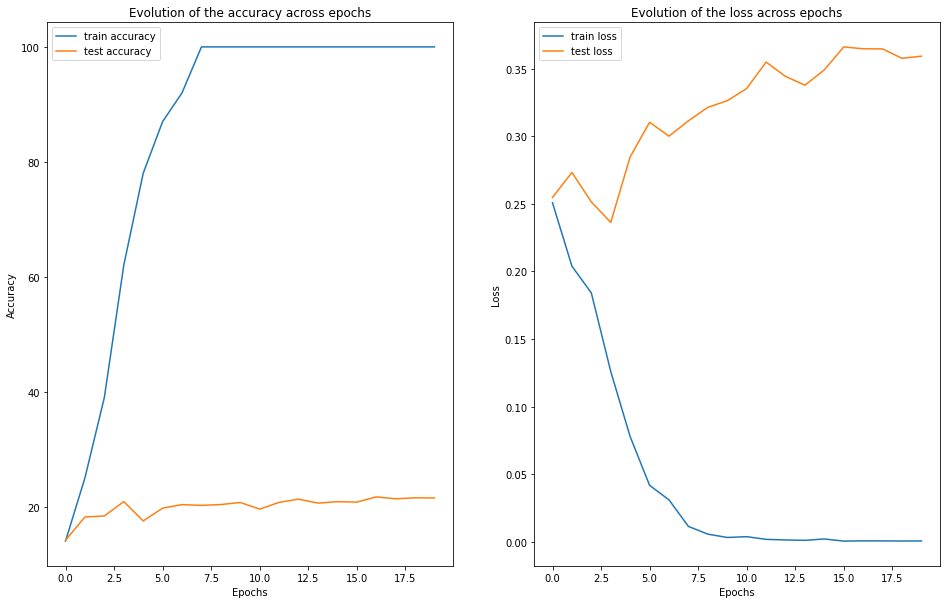

In [12]:
plot_model_results(train_accuracies, test_accuracies, train_losses, test_losses)

The same GitHub repository from which the ResNet code has been extracted (https://github.com/kuangliu/pytorch-cifar) provides a list of the accuracy achieved by different models on the whole CIFAR10 dataset. For ResNet18, the test accuracy on the whole dataset is 93.02%.

Below is given the summary of the training:


| Model | Number of  epochs  | Train accuracy | Test accuracy | Full Dataset Test accuracy |
|------|------|------|------|------|
|   RestNet18  | 20 | 100.0% | 21.5% | 93.02% |

So as predicted in the second question, it is very easy to overfit with such small dataset, so we need to investigate transfer learning techniques.

# Transfer learning

We propose to use pre-trained models on a classification task, in order to improve the results of our setting.

## ImageNet features

Now, we will use a model pre-trained on ImageNet and see how well it performs on CIFAR. A list of ImageNet pre-trained models is available on : https://pytorch.org/vision/stable/models.html

__Question 4 (3 points) :__ Pick a model from the list above, adapt it for CIFAR and retrain its final layer (or a block of layers, depending on the resources to which you have access to). Report its accuracy.

In [13]:
def load_pretrained_model(model_function, n_classes: int = 10):
  model = model_function(pretrained=True)

  # First step: freeze the block 
  # we don't want to retrain
  for param in model.parameters():
    param.requires_grad = False

  # Second step: replace the fully connected layer
  # to match the number of classes
  in_features = model.fc.in_features
  model.fc = nn.Linear(in_features, n_classes)

  return model


In [14]:
# https://pytorch.org/vision/stable/models.html indicates shape recommandation 
# as well as the normalization that needs to be used when considering 
# the pretrained model

image_net_size = (224, 224)
mean_image_net = (0.485, 0.456, 0.406)
std_image_net = (0.229, 0.224, 0.225)

transform_train_set = transforms.Compose([
    transforms.Resize(image_net_size),
    transforms.ToTensor(),
    transforms.Normalize(mean_image_net, std_image_net),
])

transform_test_set = transforms.Compose([
    transforms.Resize(image_net_size),
    transforms.ToTensor(),
    transforms.Normalize(mean_image_net, std_image_net),
])

cifar_10_dataset = CIFAR10Dataset(
    file_location="./",
    transform_train=transform_train_set,
    transform_test=transform_test_set,
)

Files already downloaded and verified
Files already downloaded and verified


First, let's load the ResNet19 pretrained model

In [15]:
resnet18_pretrained = load_pretrained_model(models.resnet18)
resnet18_pretrained = resnet18_pretrained.to(device)
classif_pipeline_pretrained = ClassificationPipeline(
    resnet18_pretrained, cifar_10_dataset
)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [16]:
(train_accuracies_pretrained,
 test_accuracies_pretrained,
 train_losses_pretrained,
 test_losses_pretrained) = classif_pipeline_pretrained.train(
    learning_rate=0.005, momentum=0.85, n_epochs=20
  )

------ Epoch 1 / 20 ------


100%|██████████| 1000/1000 [00:29<00:00, 33.93it/s]


------ Epoch 2 / 20 ------


100%|██████████| 1000/1000 [00:29<00:00, 34.46it/s]


------ Epoch 3 / 20 ------


100%|██████████| 1000/1000 [00:28<00:00, 35.05it/s]


------ Epoch 4 / 20 ------


100%|██████████| 1000/1000 [00:29<00:00, 34.17it/s]


------ Epoch 5 / 20 ------


100%|██████████| 1000/1000 [00:29<00:00, 34.06it/s]


------ Epoch 6 / 20 ------


100%|██████████| 1000/1000 [00:35<00:00, 28.33it/s]


------ Epoch 7 / 20 ------


100%|██████████| 1000/1000 [00:29<00:00, 33.96it/s]


------ Epoch 8 / 20 ------


100%|██████████| 1000/1000 [00:29<00:00, 34.25it/s]


------ Epoch 9 / 20 ------


100%|██████████| 1000/1000 [00:30<00:00, 33.10it/s]


------ Epoch 10 / 20 ------


100%|██████████| 1000/1000 [00:29<00:00, 34.22it/s]


------ Epoch 11 / 20 ------


100%|██████████| 1000/1000 [00:30<00:00, 32.73it/s]


------ Epoch 12 / 20 ------


100%|██████████| 1000/1000 [00:29<00:00, 33.93it/s]


------ Epoch 13 / 20 ------


100%|██████████| 1000/1000 [00:29<00:00, 33.98it/s]


------ Epoch 14 / 20 ------


100%|██████████| 1000/1000 [00:29<00:00, 34.22it/s]


------ Epoch 15 / 20 ------


100%|██████████| 1000/1000 [00:29<00:00, 34.06it/s]


------ Epoch 16 / 20 ------


100%|██████████| 1000/1000 [00:29<00:00, 34.02it/s]


------ Epoch 17 / 20 ------


100%|██████████| 1000/1000 [00:29<00:00, 33.92it/s]


------ Epoch 18 / 20 ------


100%|██████████| 1000/1000 [00:29<00:00, 34.06it/s]


------ Epoch 19 / 20 ------


100%|██████████| 1000/1000 [00:29<00:00, 33.82it/s]


------ Epoch 20 / 20 ------


100%|██████████| 1000/1000 [00:29<00:00, 34.21it/s]


Final training accuracy: 100.0
Final test accuracy: 51.2


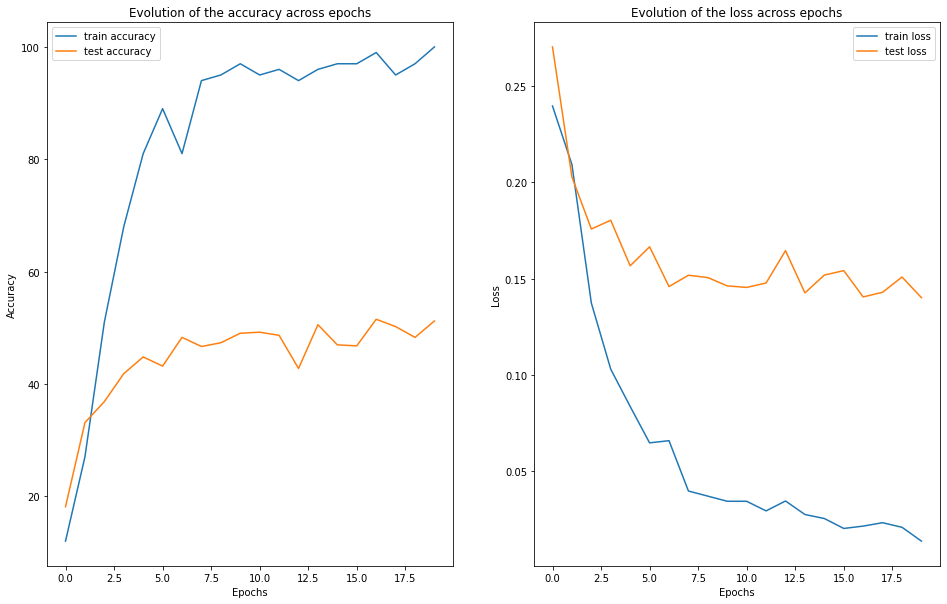

In [17]:
plot_model_results(
    train_accuracies_pretrained,
    test_accuracies_pretrained,
    train_losses_pretrained,
    test_losses_pretrained
)

| Model | Number of  epochs  | Train accuracy | Test accuracy |
|------|------|------|------|
|   RestNet18 Pretrained  | 20 | 100.0% | 51.2% |

We can notice a improvement in terms of Test accuracy (~multiplied by 2 compared to the training from scratch).

# Incorporating priors
Geometrical priors are appealing for image classification tasks. 
A color image $x$ can be seen as a function: $\mathbb{S}\rightarrow\mathbb{R}^3$, where $\mathbb{S} \subset \mathbb{R}^2$ is the image support.
Let us consider transformations $\mathcal{T}$ of possible inputs $x$. For instance, if an image had infinite support, a translation $\mathcal{T}_a$ of an image $x$ by a shift $a$ would lead to a new infinite-support image $\mathcal{T}_a(x)$, described at each pixel $u$ by :

$$\forall u, \mathcal{T}_a(x)(u)=x(u-a)\,.$$

__Question 5 (1.5 points) :__ Explain the issues when dealing with translations, rotations, scaling effects, color changes on $32\times32$ images. Propose several ideas to tackle them.

Geometric transformations are usually performs on image whose size is big enough to prevent loosing the coherence of the image. Here, in the CIFAR10 dataset, we are dealing with $32\times32$ images, which can lead to some problem when performing geometric transformations. Indeed, for example, a translation of a too high number of pixels could result in an image where the main object that need to be classified is cut in half. Therefore, to tackle this issue, we should be careful to perform translation of only a few pixels. The same issue arises when it comes to rotation. Indeed, when performing a rotation, we then need to crop the image (to remove for example the black boarder induced by some padding). For rotation with parameter around $\frac{\pi}{4}$, this results to a lot of cropping, thus we loose an important part of the image. We thus may have to limit us to small rotations.

## Data augmentations

__Question 6 (3 points) :__ Propose a set of geometric transformations beyond translation, and incorporate them in your training pipeline. Train the model of the __Question 3__ with them and report the accuracies.
You can use tools from https://pytorch.org/vision/stable/transforms.html 

In [21]:
# Build the datasets
# and apply geometric transformation to the training set

min_degree = 0
max_degree = 25

transform_train_set = transforms.Compose([
    transforms.RandomHorizontalFlip(0.6),
    transforms.RandomVerticalFlip(0.6),
    transforms.RandomCrop((32, 32)),
    transforms.ColorJitter(brightness=0.2, contrast=0.03, saturation=0.03, hue=0.03),
    transforms.RandomAffine(  # handles both rotation and translation
        degrees=(min_degree, max_degree),
        translate=(0.0, 0.1),
    ),
    transforms.ToTensor(),
    transforms.Normalize(train_mean, train_std),
])

transform_test_set = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(train_mean, train_std),
])

cifar_10_dataset_augmented = CIFAR10Dataset(
    file_location="./",
    transform_train=transform_train_set,
    transform_test=transform_test_set,
)

Files already downloaded and verified
Files already downloaded and verified


In [24]:
# Train the ResNet18 architecture with the augmented
# dataset

res_net_18_augmented = ResNet18()
res_net_18_augmented = res_net_18_augmented.to(device)
classif_pipeline_augmented = ClassificationPipeline(
    res_net_18_augmented,
     cifar_10_dataset_augmented,
)

(train_accuracies_augmented,
 test_accuracies_augmented,
 train_losses_augmented,
 test_losses_augmented) = classif_pipeline_augmented.train(
    learning_rate=0.005, momentum=0.85, n_epochs=20
  )

------ Epoch 1 / 20 ------


100%|██████████| 1000/1000 [00:09<00:00, 101.46it/s]


------ Epoch 2 / 20 ------


100%|██████████| 1000/1000 [00:09<00:00, 101.54it/s]


------ Epoch 3 / 20 ------


100%|██████████| 1000/1000 [00:09<00:00, 100.75it/s]


------ Epoch 4 / 20 ------


100%|██████████| 1000/1000 [00:09<00:00, 100.98it/s]


------ Epoch 5 / 20 ------


100%|██████████| 1000/1000 [00:09<00:00, 101.24it/s]


------ Epoch 6 / 20 ------


100%|██████████| 1000/1000 [00:09<00:00, 100.26it/s]


------ Epoch 7 / 20 ------


100%|██████████| 1000/1000 [00:10<00:00, 98.95it/s]


------ Epoch 8 / 20 ------


100%|██████████| 1000/1000 [00:09<00:00, 100.20it/s]


------ Epoch 9 / 20 ------


100%|██████████| 1000/1000 [00:09<00:00, 100.72it/s]


------ Epoch 10 / 20 ------


100%|██████████| 1000/1000 [00:09<00:00, 100.25it/s]


------ Epoch 11 / 20 ------


100%|██████████| 1000/1000 [00:10<00:00, 99.63it/s] 


------ Epoch 12 / 20 ------


100%|██████████| 1000/1000 [00:09<00:00, 100.14it/s]


------ Epoch 13 / 20 ------


100%|██████████| 1000/1000 [00:10<00:00, 99.94it/s]


------ Epoch 14 / 20 ------


100%|██████████| 1000/1000 [00:10<00:00, 99.60it/s]


------ Epoch 15 / 20 ------


100%|██████████| 1000/1000 [00:09<00:00, 100.53it/s]


------ Epoch 16 / 20 ------


100%|██████████| 1000/1000 [00:10<00:00, 98.96it/s]


------ Epoch 17 / 20 ------


100%|██████████| 1000/1000 [00:10<00:00, 98.71it/s]


------ Epoch 18 / 20 ------


100%|██████████| 1000/1000 [00:10<00:00, 99.90it/s]


------ Epoch 19 / 20 ------


100%|██████████| 1000/1000 [00:09<00:00, 100.28it/s]


------ Epoch 20 / 20 ------


100%|██████████| 1000/1000 [00:10<00:00, 99.92it/s] 


Final training accuracy: 42.0
Final test accuracy: 20.04


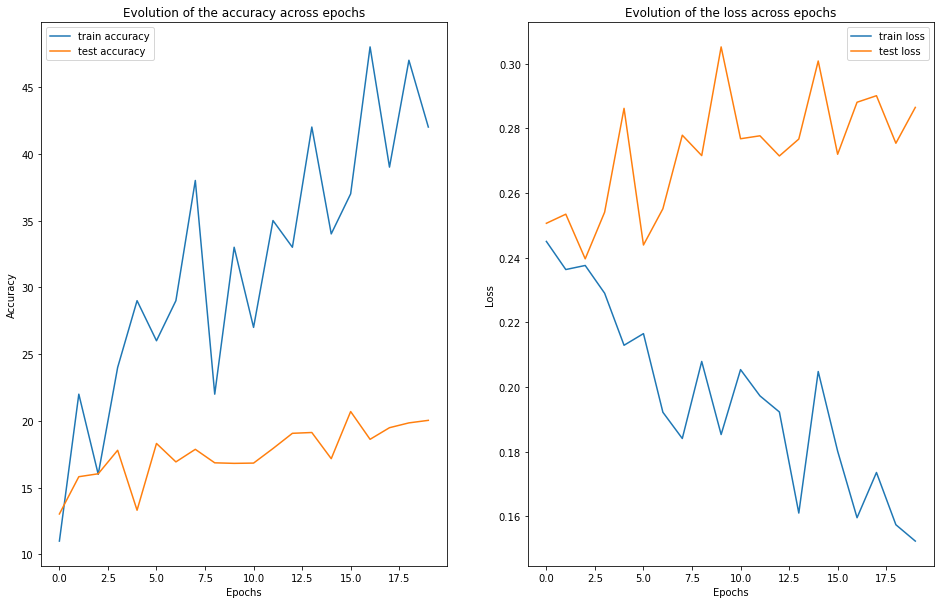

In [26]:
plot_model_results(
    train_accuracies_augmented,
    test_accuracies_augmented,
    train_losses_augmented,
    test_losses_augmented
)

| Model | Number of  epochs  | Train accuracy | Test accuracy |
|------|------|------|------|
|   RestNet18 Augmentation  | 20 | 42.0% | 20.04% |
|   RestNet18 Augmentation  | 100 | 96% | 25.18% |

# Conclusions

__Question 7 (5 points) :__ Write a short report explaining the pros and the cons of each method you implemented. 25% of the grade of this project will correspond to this question, thus, it should be done carefully. In particular, please add a plot that will summarize all your numerical results.

In this practical session, we have been dealing with small datasets to solve a classification task. More precisely, we have been training different architectur with a training set which is a subset of 100 labeled examples of the CIFAR10 dataset. We carried out different approaches to train classification neural networks with such dataset, and analyzed the difference in terms of perforrmance

___Basline: ResNet18___

First, we have been using a convolutional networks with residual connection called ResNet18. It is a classic architecture that is originally trained on ImageNet and provide good performance. However, we were here interested in looking at the performance of such architecture by training it from scrath (i.e we didn't keep the weights of such arhictecture trained on ImageNet), using only the 100 examples in $\mathcal{X}_{\text{train}}$.
We have been training it using the SGD optimize (learning rate 0.005, momentum 0.85) for 20 epochs, and tested it on the 1000 examples from the CIFAR10 test set. We also note that we normalized the dataset, by computing the mean and standard deviation on the 100 training samples. We got a train accuracy of 99% and a test accuracy of 20.41%. The test accuracy on the full dataset has been found on https://github.com/kuangliu/pytorch-cifar, and is of 93.02%. We can thus notice that the main cons of this method is the massive overfit it leads to, which is namely due to the high number of parameters of such architectures that require more examples to be able to have correct generalization capacities. Nevertheless, training such network didn't require a lot of computational time as we only used 100 examples and was a good start to better understand the effect of using small datasets.

__Transfer Learning__

In a second step, we tried transfert learning, i.e we took the ResNet18 architecture pretrained on ImageNet, and we froze the convolutionnal part and retrained the last fully connected layer using our 100 labels examples of CIFAR10. We have been using the same training procedure, i.e SGD (same hyperparameters) during 20 epochs. Notice that for this training, we didn't use the mean and standard deviation computed on the training set, but instead, we have been using the mean and standard deviation of the ImageNet training set used to pretrain the model. This seems necessary to take full advantage of the trained convolutionnal network that have learnt to analyze images scaled with the training set of ImageNet. We got a training accuracy of 99.0% (so same as before), but a test accuracy of 50.38%. First, we should notice that we didn't reach such a good performance as the one given previously on the whole CIFAR10 dataset (93.02%). This can be due to the fact that ImageNet and CIFAR10 datasets don't have images of the same size / resolution, therefore a resize had to be performed, which blurred the imageand could potentially lead to poorer performance. Nevertheless, we notice the increase in test accuracy from 20.41% to 50.38%, which means that our network has better generalization capacities. This can be explained by the fact the the convolutionnal networks, trained on ImageNet, have already learnt to capture essential features for images (low levels features like edges, high levels features like shapes...). This features are general enough to be applicable to any image, hence the gain in terms of test accuracy.

__Data Augmentation__

Finally, I have been trying to train from scratch the ResNet18 architecture with the small datasets of 100 examples by adding a data augmentation step. First, we did a qualitative analysis of the potential issues of using geometric transformations on small images ($32 \times 32$ images), like translation of many pixels or rotation with high angles, that coult result in a loss of informaiton in the image, and thus potentially a loss in the model's performance. We then trained the model with the same training setting as before, and got 42.0 of train accuracy and 20.04 of test accuracy. I have been using the following transform for the data augmentation:

- Random horizontal flip (probaibility 0.6)
- Random vertical flip (probaibility 0.6)
- Random Cropping
- Color Jittering
- Random Affine transformation (combination of translation of maximum 10% of the size of the image ; and rotation with angle between 0 and 25 degrees)

As in all previous training, the dataset has been normlized.
We observed a drop in terms of training accuracy (52%), that can be explained by the fact that the network didn't see exactly yhe same images at each epoch, and thus was less able to exactly overfit and the 100 images. However, we got quite the same test accuracy as in the baseline (20.15%), from which we can deduced that we have started to solve the overfit issue, which was expected from the data augmentation step.
Nevertheless, I have also tried to train the same network, with the same data augmentation steps, with more epochs (100), and we observe the same behavior as in the baseline (training accuracy of 96.0% and test accuracy of 25.18%), which means that the model still suffers from overfitting, and retraining such a big network from scratch with only 100 examples is not enough to get good generalization capacities, even we see a slight improvement (training accuracy decreased a bit and we gain some % in the test accuracy).


__Summary__

Below is given a summary of the results, as well as a corresponding plot.

| Model | Number of  epochs  | Train accuracy | Test accuracy | Full Dataset Test accuracy |
|------|------|------|------|------|
|   RestNet18  | 20 | 100.0% | 21.5% | 93.02% |
|   RestNet18 Pretrained  | 20 | 100.0% | 51.2% | XXX% |
|   RestNet18 Augmentation  | 20 | 42.0% | 20.04% | XXX% |
|   RestNet18 Augmentation  | 100 | 96.0% | 25.18% | XXX% |


Therefore, from these different experiments, we saw that training neural networks with very small datasets can easily lead to overfit. However, weak supervision techniques, namely Transfer Learning which has been studied here, are a good way to go to when dealing with small datasets. Their success for example in image classificaiton comes from the possibility to re-use the universal features learnt by convolutional networks, and apply them to other datasets. Finally, a more "hand crafted" way to handle small dataset was to look at data augmentation by using different geometrical transformation. We noticed that for the same training settings, a slight decrease of the overfit, but globally, the results remains worse than the Transfer learning methods. In the bonus part, we will look at another weak supervision techniques, which will be using an auto encoder as an unsupervised way to learn features. 

Text(0.5, 1.0, 'Summary of the Weak supervision methods')

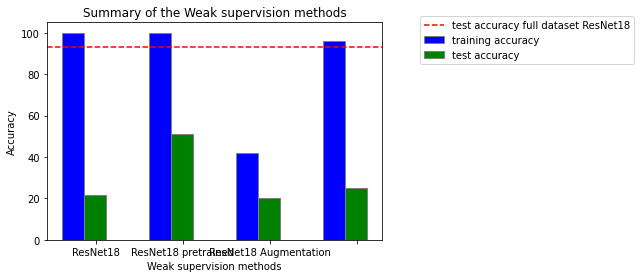

In [27]:
# help from https://www.geeksforgeeks.org/bar-plot-in-matplotlib/
# to customize the barplot

training_accuracies = [100.0, 100.0, 42.0, 96.0]
test_accuracies = [21.5, 51.2, 20.04, 25.18]
full_dataset_test_accuracy = 93.02

training_bars = np.arange(len(training_accuracies))
testing_bars = [x + 0.25 for x in training_bars]

plt.bar(training_bars, training_accuracies, color ='b', width = 0.25, edgecolor ='grey', label ='training accuracy')
plt.bar(testing_bars, test_accuracies, color ='g', width = 0.25, edgecolor ='grey', label ='test accuracy')

plt.xticks([r + 0.26 for r in range(len(training_accuracies))],
        ["ResNet18", "ResNet18 pretrained", "ResNet18 Augmentation"])

plt.axhline(y=full_dataset_test_accuracy,
            color = 'r',
            linestyle = '--',
            label="test accuracy full dataset ResNet18"
)
plt.xlabel("Weak supervision methods")
plt.ylabel("Accuracy")
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.title("Summary of the Weak supervision methods")

# Weak supervision

__Bonus \[open\] question (up to 4 points) :__ Pick a weakly supervised method that will potentially use $\mathcal{X}_{\text{nolabel}}\cup\mathcal{X}_{\text{train}}$ to train a model (a subset of $\mathcal{X}_{\text{nolabel}}$ is also fine). Evaluate it and report the accuracies. You should be careful in the choice of your method, in order to avoid heavy computational effort.

For this question, I have chosen to build and train a convolutional auto-encoder trained on $\mathcal{X}_{\text{nolabel}}\cup\mathcal{X}_{\text{train}}$. Then, the latent dimension will be used to train fully connected layers of a second network (i.e we will freeze the weights of the encoder and only train the fully connected layers) on $\mathcal{X}_{\text{train}}$ for the classification task 

In [28]:
class Encoder(nn.Module):
  def __init__(self):
    super(Encoder, self).__init__()
    self.convolutional_block = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=(5, 5), stride=1),
            nn.Conv2d(32, 64, kernel_size=(5, 5), stride=1),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2),
            nn.ReLU(),

            nn.Conv2d(64, 128, kernel_size=(5, 5), stride=1),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(kernel_size=2),
            nn.ReLU(),
        )
    
    self.linear_block = nn.Sequential(
            nn.Linear(2048, 512),
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.ReLU(),
        )
    
  def forward(self, x):
      x = self.convolutional_block(x)
      x = nn.Flatten()(x)
      x = self.linear_block(x)
      return x


class Decoder(nn.Module):
  def __init__(self):
    super(Decoder, self).__init__()
    self.linear_block = nn.Sequential(
            nn.Linear(128, 512),
            nn.ReLU(),
            nn.Linear(512, 2048),
            nn.ReLU(),
        )
  
    self.convolutional_block = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=(5, 5), stride=1),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2),
            nn.ReLU(),

            nn.ConvTranspose2d(64, 32, kernel_size=(7, 7), stride=1),
            nn.ConvTranspose2d(32, 3, kernel_size=(3, 3), stride=3, output_padding=2),
            nn.ReLU(),

        )
    
  def forward(self, x):
      x = self.linear_block(x)
      x = nn.Unflatten(dim=1, unflattened_size=(128, 4, 4))(x)
      x = self.convolutional_block(x)
      return x


class AutoEncoder(nn.Module):
  def __init__(self, encoder, decoder):
    super(AutoEncoder, self).__init__()
    self.encoder = encoder
    self.decoder = decoder

  def forward(self, x):
    x = self.encoder(x)
    x = self.decoder(x)
    return x

  def train(self, dataset, n_epochs, learning_rate, momentum):
    # Define the optimizing objects
        optimizer = torch.optim.SGD(
            self.parameters(),
            lr=learning_rate,
            momentum=momentum,
        )
        learning_rate_scheduler = StepLR(
            optimizer,
            step_size=30,
            gamma=0.1,
        )
        criterion = nn.MSELoss()
        
        train_losses = []
        test_losses = []
        
        for i in range(n_epochs):
            print(f"------ Epoch {i+1} / {n_epochs} ------")
            train_accuracy = 0
            train_loss = 0
            test_accuracy = 0
            test_loss = 0
            n_examples = 0
            
            for images, _ in tqdm(iter(dataset.train_loader)):
                # Send to GPU if available
                images = images.to(device)

                # Add the current number of examples in the batch
                n_examples += images.shape[0]
                
                # One training step
                optimizer.zero_grad()
                reconstruction = self(images)
                loss = criterion(reconstruction, images)
                loss.backward()
                optimizer.step()
              
                train_loss += loss

            for images, _ in tqdm(iter(dataset.train_loader_no_label)):
                # Send to GPU if available
                images = images.to(device)

                # Add the current number of examples in the batch
                n_examples += images.shape[0]
                
                # One training step
                optimizer.zero_grad()
                reconstruction = self(images)
                loss = criterion(reconstruction, images)
                loss.backward()
                optimizer.step()
              
                train_loss += loss
                
            # Run on test
            n_examples_test = 0
            for test_images, _ in tqdm(iter(dataset.test_loader)):
                test_images = test_images.to(device)
                n_examples_test += test_images.shape[0]
                with torch.no_grad():
                    reconstruction_test = self(test_images)
                    loss = criterion(reconstruction_test, test_images)
                    test_loss += loss
                    
            # End of epoch, save losses
            train_losses.append(train_loss.cpu().detach() / n_examples)
            test_losses.append(test_loss.cpu() / n_examples_test)
            
        return train_losses, test_losses


In [29]:
encoder = Encoder().to(device)
decoder = Decoder().to(device)

auto_encoder = AutoEncoder(encoder, decoder)

In [30]:
transform_train_set = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(train_mean, train_std),
])

transform_test_set = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(train_mean, train_std),
])

cifar_10_dataset_reduced = CIFAR10Dataset(
    file_location="./",
    n_no_labels_examples=20000,
    transform_train=transform_train_set,
    transform_test=transform_test_set,
)

train_losses, test_losses = auto_encoder.train(
    dataset=cifar_10_dataset_reduced,
    n_epochs=20,
    learning_rate=0.1,
    momentum=0.85,
)

Files already downloaded and verified
Files already downloaded and verified
------ Epoch 1 / 20 ------


100%|██████████| 1000/1000 [00:06<00:00, 145.46it/s]


------ Epoch 2 / 20 ------


100%|██████████| 1000/1000 [00:06<00:00, 147.53it/s]


------ Epoch 3 / 20 ------


100%|██████████| 1000/1000 [00:06<00:00, 150.30it/s]


------ Epoch 4 / 20 ------


100%|██████████| 1000/1000 [00:06<00:00, 145.95it/s]


------ Epoch 5 / 20 ------


100%|██████████| 1000/1000 [00:06<00:00, 146.07it/s]


------ Epoch 6 / 20 ------


100%|██████████| 1000/1000 [00:06<00:00, 145.82it/s]


------ Epoch 7 / 20 ------


100%|██████████| 1000/1000 [00:06<00:00, 144.12it/s]


------ Epoch 8 / 20 ------


100%|██████████| 1000/1000 [00:06<00:00, 149.18it/s]


------ Epoch 9 / 20 ------


100%|██████████| 1000/1000 [00:06<00:00, 145.17it/s]


------ Epoch 10 / 20 ------


100%|██████████| 1000/1000 [00:06<00:00, 146.62it/s]


------ Epoch 11 / 20 ------


100%|██████████| 1000/1000 [00:06<00:00, 145.13it/s]


------ Epoch 12 / 20 ------


100%|██████████| 1000/1000 [00:06<00:00, 144.87it/s]


------ Epoch 13 / 20 ------


100%|██████████| 1000/1000 [00:06<00:00, 143.43it/s]


------ Epoch 14 / 20 ------


100%|██████████| 1000/1000 [00:06<00:00, 147.72it/s]


------ Epoch 15 / 20 ------


100%|██████████| 1000/1000 [00:06<00:00, 146.70it/s]


------ Epoch 16 / 20 ------


100%|██████████| 1000/1000 [00:06<00:00, 144.12it/s]


------ Epoch 17 / 20 ------


100%|██████████| 1000/1000 [00:06<00:00, 146.88it/s]


------ Epoch 18 / 20 ------


100%|██████████| 1000/1000 [00:06<00:00, 147.19it/s]


------ Epoch 19 / 20 ------


100%|██████████| 1000/1000 [00:06<00:00, 144.71it/s]


------ Epoch 20 / 20 ------


100%|██████████| 1000/1000 [00:06<00:00, 144.52it/s]


Let's have a look at the training and test loss for the auto encoder model:

Text(0, 0.5, 'Loss')

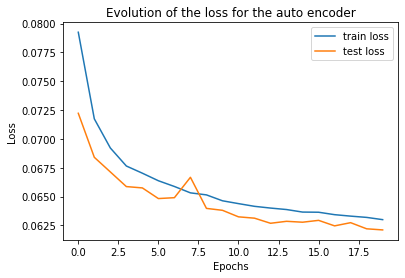

In [31]:
plt.plot(train_losses, label="train loss")
plt.plot(test_losses, label="test loss")
plt.legend()
plt.title("Evolution of the loss for the auto encoder")
plt.xlabel("Epochs")
plt.ylabel("Loss")

Let's have a look at the reconstruction version of an image (the color aren't really relevant here as we are using the noramlized dataset, but the idea was to see if we get back shapes etc..)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Reconstructed image')

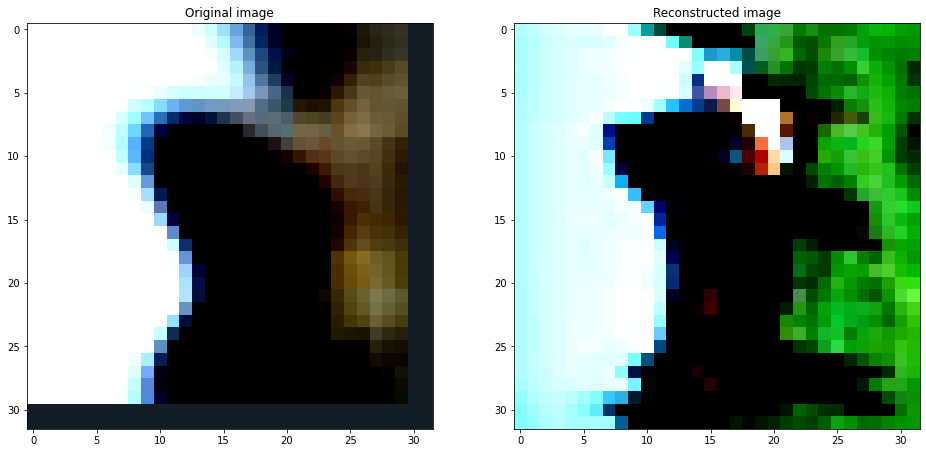

In [33]:
first_batch_images, first_batch_labels = iter(cifar_10_dataset_reduced.train_loader).next()

first_batch_images = first_batch_images.to(device)
reconstructions = auto_encoder(first_batch_images).cpu().detach()

index = 7

fig, ax = plt.subplots(1, 2, figsize=(16, 10))

plt.subplot(1, 2, 1)
plt.imshow(reconstructions[index].T)
plt.title("Original image")

plt.subplot(1, 2, 2)
plt.imshow(first_batch_images[index].cpu().T)
plt.title("Reconstructed image")

We now build the classifier which will consists in the encoder trained before (for features extraction), followed by 2 fully connected layers. Only these two last layers will be trained on the 100 labeled examples of the CIFAR10 dataset.

In [45]:
class WeakClassifier(nn.Module):
  def __init__(self, encoder, n_classes):
    super(WeakClassifier, self).__init__()
    self.encoder = encoder

    self.fc_layers = nn.Sequential(
            nn.Linear(128, n_classes),
        )

  def forward(self, x):
    x = self.encoder(x)
    x = self.fc_layers(x)
    return x

In [46]:
weak_classifier = WeakClassifier(encoder, 10)

weak_classifier = weak_classifier.to(device)

classif_pipeline_weak = ClassificationPipeline(
    weak_classifier,
    cifar_10_dataset_reduced,
)

In [47]:
for param in weak_classifier.encoder.parameters():
  param.requires_grad = False

In [48]:
(train_accuracies_weak,
 test_accuracies_weak,
 train_losses_weak,
 test_losses_weak) = classif_pipeline_weak.train(
    learning_rate=0.005, momentum=0.85, n_epochs=20
  )

------ Epoch 1 / 20 ------


100%|██████████| 1000/1000 [00:07<00:00, 133.10it/s]


------ Epoch 2 / 20 ------


100%|██████████| 1000/1000 [00:07<00:00, 133.69it/s]


------ Epoch 3 / 20 ------


100%|██████████| 1000/1000 [00:07<00:00, 133.17it/s]


------ Epoch 4 / 20 ------


100%|██████████| 1000/1000 [00:07<00:00, 135.52it/s]


------ Epoch 5 / 20 ------


100%|██████████| 1000/1000 [00:07<00:00, 134.31it/s]


------ Epoch 6 / 20 ------


100%|██████████| 1000/1000 [00:07<00:00, 133.59it/s]


------ Epoch 7 / 20 ------


100%|██████████| 1000/1000 [00:07<00:00, 133.34it/s]


------ Epoch 8 / 20 ------


100%|██████████| 1000/1000 [00:07<00:00, 134.17it/s]


------ Epoch 9 / 20 ------


100%|██████████| 1000/1000 [00:07<00:00, 133.79it/s]


------ Epoch 10 / 20 ------


100%|██████████| 1000/1000 [00:07<00:00, 133.83it/s]


------ Epoch 11 / 20 ------


100%|██████████| 1000/1000 [00:08<00:00, 118.32it/s]


------ Epoch 12 / 20 ------


100%|██████████| 1000/1000 [00:07<00:00, 133.23it/s]


------ Epoch 13 / 20 ------


100%|██████████| 1000/1000 [00:07<00:00, 133.20it/s]


------ Epoch 14 / 20 ------


100%|██████████| 1000/1000 [00:07<00:00, 133.37it/s]


------ Epoch 15 / 20 ------


100%|██████████| 1000/1000 [00:07<00:00, 134.53it/s]


------ Epoch 16 / 20 ------


100%|██████████| 1000/1000 [00:07<00:00, 134.28it/s]


------ Epoch 17 / 20 ------


100%|██████████| 1000/1000 [00:07<00:00, 133.88it/s]


------ Epoch 18 / 20 ------


100%|██████████| 1000/1000 [00:07<00:00, 133.66it/s]


------ Epoch 19 / 20 ------


100%|██████████| 1000/1000 [00:07<00:00, 132.51it/s]


------ Epoch 20 / 20 ------


100%|██████████| 1000/1000 [00:07<00:00, 134.08it/s]


Final training accuracy: 56.99999999999999
Final test accuracy: 13.81


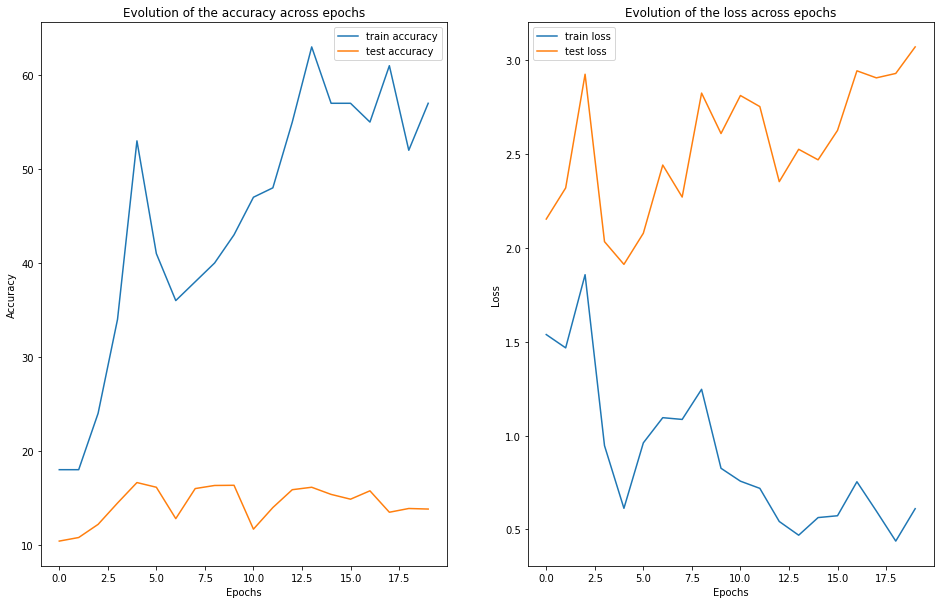

In [49]:
plot_model_results(
    train_accuracies_weak,
    test_accuracies_weak,
    train_losses_weak,
    test_losses_weak
)

Below is given the table of the performance:

| Model | Number of  epochs  | Train accuracy | Test accuracy |
|------|------|------|------|
|   Weak classifier (with pretrained encoder) | 20 | 57.0% | 13.81% |

For this method, I have been using an autoencoder trained on 100 labeled examples and 20000 non labeled examples. Then, I have trained a classifier (a single fully connected layers). The performance of the classifier are worse than the one we got using transfer learning (13.81% test accuracy). This can be due to the fact that the classifier model is too simple (only one additional layer which is trained on the 100 examples). However, we notice that the gap between train and test accuracies is more narrow than previously, which could potentially mean that unsupervised method used with the non labaled data made it possible to learn features that were universal enough. Possible ways of improvement would be to make the last classifier more complex, but some trials have indicated that a similar behavior as in Question 3 was occuring (very high train accuracy and low test accuracies). Therefore, it might be necessary either to regularize the training procedure (dropout, early stopping...) or to use more data in the unsupervised step. 

Thanks for reading!